In [1]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from likelihood_mesonh import likelihood_mesonh
import sys  # to put the SCM into the PYTHONPATH
sys.path.append('edmf_ocean/library/F2PY')
from sys import exit
import time as TIME
import xarray as xr
from scipy.interpolate import interp1d
import scipy.signal
from scm_class import SCM
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
from case_configs import case_params, default_params
from multiprocess import Pool #multiprocessING cannot handle locally defined functions, multiprocess can
import subprocess
from test_version_edmf_ocean import check_edmf_ocean_version
check_edmf_ocean_version()
from interpolate_LES_on_SCM_grids import regrid_and_save


## Load the data
data = az.from_netcdf('MCMC_output/MAP_error_run.nc')

## convert to xarray dataset
ds = az.convert_to_dataset(data)

opening ./data/FC500/GN_01.1.OC_01.000.nc
Interpolate LES on SCM with grid spec {'nz': 100, 'h0': 1000.0, 'thetas': 6.5}
Interpolated LES saved at ./data/FC500/FC500_interpolated_on_SCM.nc
opening ./data/W005_C500_NO_COR/GN_01.1.OC_01.000.nc
Interpolate LES on SCM with grid spec {'nz': 100, 'h0': 1000.0, 'thetas': 6.5}
Interpolated LES saved at ./data/W005_C500_NO_COR/W005_C500_NO_COR_interpolated_on_SCM.nc
opening ./data/FC500/FC500_interpolated_on_SCM.nc
opening ./data/W005_C500_NO_COR/W005_C500_NO_COR_interpolated_on_SCM.nc


In [2]:
ds['likelihood'][0].max()
ds['likelihood'][0].min()

<xarray.DataArray 'likelihood' ()>
array(-2.9629237e+14)
Coordinates:
    chain    int64 0

In [3]:
ds

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 40000)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 ... 39994 39995 39996 39997 39998 39999
Data variables:
    Cdet        (chain, draw) float64 ...
    Cent        (chain, draw) float64 ...
    bc_ap       (chain, draw) float64 ...
    delta_bkg   (chain, draw) float64 ...
    likelihood  (chain, draw) float64 ...
    log_wp_0    (chain, draw) float64 ...
    up_c        (chain, draw) float64 ...
    wp_0        (chain, draw) float64 ...
    wp_a        (chain, draw) float64 ...
    wp_b        (chain, draw) float64 ...
    wp_bp       (chain, draw) float64 ...
Attributes:
    created_at:                 2024-10-26T13:31:28.078112+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2
    sampling_time:              57011.942348480225
    tuning_steps:               3000

In [4]:
slicer = ds['likelihood'][0] > 0.1 * ds['likelihood'][0].max() 
ds['likelihood'][0][slicer]
ds_sliced = { key: ds[key][0, slicer] for key in ds.data_vars.keys() }

nsubsample = len(ds_sliced['likelihood'])
number_of_draws = 100
subsample_indices = np.random.choice(nsubsample, number_of_draws, replace=False)
ds_subsampled = {key: ds_sliced[key][subsample_indices] for key in ds_sliced.keys()}

# ds_sliced['likelihood'][subsample_indices]
ds_subsampled



{'Cdet': <xarray.DataArray 'Cdet' (draw: 100)>
 [100 values with dtype=float64]
 Coordinates:
     chain    int64 0
   * draw     (draw) int64 39383 38851 38513 39322 ... 39556 37706 37333 38055,
 'Cent': <xarray.DataArray 'Cent' (draw: 100)>
 [100 values with dtype=float64]
 Coordinates:
     chain    int64 0
   * draw     (draw) int64 39383 38851 38513 39322 ... 39556 37706 37333 38055,
 'bc_ap': <xarray.DataArray 'bc_ap' (draw: 100)>
 [100 values with dtype=float64]
 Coordinates:
     chain    int64 0
   * draw     (draw) int64 39383 38851 38513 39322 ... 39556 37706 37333 38055,
 'delta_bkg': <xarray.DataArray 'delta_bkg' (draw: 100)>
 [100 values with dtype=float64]
 Coordinates:
     chain    int64 0
   * draw     (draw) int64 39383 38851 38513 39322 ... 39556 37706 37333 38055,
 'likelihood': <xarray.DataArray 'likelihood' (draw: 100)>
 [100 values with dtype=float64]
 Coordinates:
     chain    int64 0
   * draw     (draw) int64 39383 38851 38513 39322 ... 39556 37706 37333 380

In [5]:
def run_scm(params_to_estimate,case,draw):
    # ====================================Run the SCM cases=======================================
    params = default_params.copy()  # Create a copy of default_params
    params.update(case_params[case])  # Update with the specific case hyperparameters in case_params[case]
    params.update(params_to_estimate) # Update with the parameters to estimate 
    params.update( {'output_filename': 'plotting_outputs/'+case+str(draw)+'.nc','write_netcdf': True})
    print('Running SCM with the following parameters:', params)
    scm = SCM(**params)
    scm.run_direct()            # Run the SCM

In [7]:
cases = ['FC500','W005_C500_NO_COR']

for draw in range(number_of_draws):
    for case in cases:
        params_to_estimate = {key: ds_subsampled[key][draw] for key in ds_subsampled.keys() if (key != 'likelihood' and key != 'log_likelihood' and key != 'log_wp_0')}
        params_to_estimate['wp0'] = params_to_estimate.pop('wp_0')  # Rename 'old_key' to 'new_key'

        run_scm(params_to_estimate=params_to_estimate,case=case,draw=draw)

Running SCM with the following parameters: {'nz': 100, 'dt': 50.0, 'h0': 1000.0, 'thetas': 6.5, 'hc': 400, 'nbhours': 72, 'outfreq': 1, 'output_filename': 'plotting_outputs/FC5000.nc', 'T0': 2.0, 'N0': 1.96200012754905e-06, 'Tcoef': 0.2048, 'SaltCst': 32.6, 'lat0': 0.0, 'sustr': 0.0, 'svstr': 0.0, 'stflx': -500.0, 'srflx': 0.0, 'ssflx': 0.0, 'eddy_diff': True, 'evd': False, 'mass_flux_tra': True, 'mass_flux_dyn': True, 'mass_flux_tke': True, 'mass_flux_tke_trplCorr': True, 'mass_flux_small_ap': True, 'lin_eos': True, 'extrap_ak_surf': True, 'tke_sfc_dirichlet': False, 'eddy_diff_tke_const': 'NEMO', 'entr_scheme': 'R10', 'Cent': <xarray.DataArray 'Cent' ()>
[1 values with dtype=float64]
Coordinates:
    chain    int64 0
    draw     int64 39383, 'Cdet': <xarray.DataArray 'Cdet' ()>
[1 values with dtype=float64]
Coordinates:
    chain    int64 0
    draw     int64 39383, 'wp_a': <xarray.DataArray 'wp_a' ()>
[1 values with dtype=float64]
Coordinates:
    chain    int64 0
    draw     int6

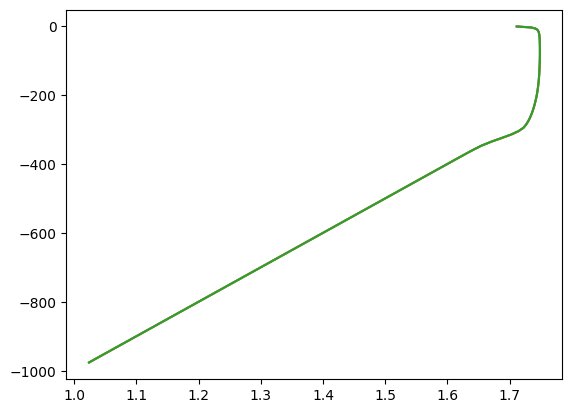

In [9]:
cases = ['FC500','W005_C500_NO_COR']

profiles = {}
for case in cases:
    profiles[case] = [None]*number_of_draws
    for draw in range(number_of_draws):
        profiles[case][draw] = xr.open_dataset('plotting_outputs/'+case+str(draw)+'.nc')

mean_temp = 1/number_of_draws* sum(profiles['FC500'][i]['temp'] for i in range(number_of_draws))
var_temp = 1/number_of_draws* sum(profiles['FC500'][i]['temp']**2 for i in range(number_of_draws)) - mean_temp**2


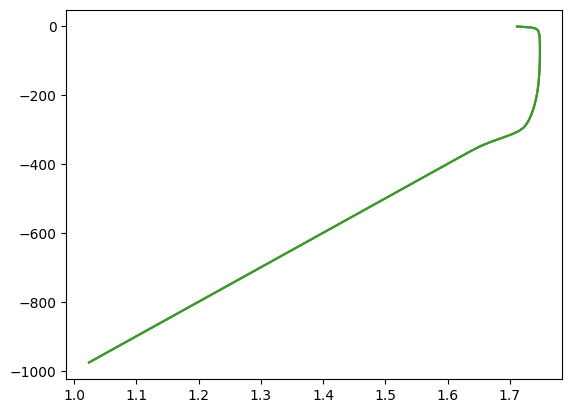

In [10]:

plt.plot(mean_temp[-1], profiles['FC500'][0]['z_r'], label='mean')
plt.plot(mean_temp[-1] + 1/np.sqrt(number_of_draws)*var_temp [-1], profiles['FC500'][0]['z_r'], label='mean')
plt.plot(mean_temp[-1] - 1/np.sqrt(number_of_draws)*var_temp [-1], profiles['FC500'][0]['z_r'], label='mean')